## Dataset

In [2]:
import os
import numpy as np
import cv2
import torch

class ImagesDataset(torch.utils.data.Dataset):

    def __init__(self, files_dir, im_width, im_height, classes, transforms=None):
        self.transforms = transforms
        self.files_dir = files_dir
        self.im_height = im_height
        self.im_width = im_width
        self.im_names = [file_name for file_name in sorted(os.listdir(files_dir)) if file_name[-4:]==".png"]
        # classes names: 0 index is reserved for background
        self.classes = [_] + classes

    def replace_negative_values(self, boxes):
        if sum(boxes[:, 0] < 0) > 0:
            boxes[:, [0, 2]] += self.im_width - 1
        if sum(boxes[:, 1] < 0) > 0:
            boxes[:, [1, 3]] += aelf.im_height - 1
        return boxes

    def __getitem__(self, idx):
        # reading the image, converting it to correct size and color and scaling  
        im_name = self.im_names[idx]
        im_path = os.path.join(self.files_dir, im_name)
        im_bgr = cv2.imread(im_path)
        im_rgb = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2RGB).astype(np.float32)
        im = cv2.resize(im_rgb, (self.im_width, self.im_height), cv2.INTER_AREA)
        im /= 255.0

        # reading the annotation file
        annot_name = im_name[:-4] + '.txt'
        annot_path = os.path.join(self.files_dir, annot_name)
        boxes = []
        labels = []
        # reading and correcting coordinates
        with open(annot_path) as file:
            for line in file:
                parsed = [float(x) for x in line.split(' ')]
                # as idx 0 is reserved for background, increasing class idx by 1
                labels.append(int(parsed[0] + 1))
                # these are absolute coordinate values (measured from 0 to 1)
                abs_xcenter, abs_ycenter = parsed[1], parsed[2]
                abs_box_w, abs_box_h = parsed[3], parsed[4]
                # recaculating them into relative coordinates
                xmin = int((abs_xcenter - (abs_box_w / 2)) * self.im_width)
                ymin = int((abs_ycenter - (abs_box_h / 2)) * self.im_height)
                xmax = int((abs_xcenter + (abs_box_w / 2)) * self.im_width)
                ymax = int((abs_ycenter + (abs_box_h / 2)) * self.im_height)
                boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # getting the areas of the boxes
        areas = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        target = {
            "boxes": boxes,
            "labels": labels,
            "area": areas,
            "iscrowd": iscrowd,
            "image_id": torch.tensor([idx])
        }

        # transforming the image
        if self.transforms:
            sample = self.transforms(image=im, bboxes=target['boxes'], labels=labels)
            im = sample['image']
            target['boxes'] = self.replace_negative_values(target['boxes'])
            target['boxes'] = torch.Tensor(sample['bboxes'])
        im = torch.as_tensor(im, dtype=torch.float32)
        im = torch.reshape(im, (3, self.im_width, self.im_height))
        
        return im, target

    def __len__(self):
        return len(self.im_names)



In [3]:
# enter a path to the labeled data in the YOLO format
files_dir = r"cv-course-data/Detection Data/data"
train_dir = files_dir + r"/train"
test_dir = files_dir + r"/test"
classnames_path = files_dir + r"/obj.names"

with open(classnames_path, "r") as file:
    class_names = [class_name[:-1] for class_name in file]    
print("Class names:", class_names)

Class names: ['teabag', 'candy']


In [4]:
dataset = ImagesDataset(train_dir, 224, 224, class_names)
print('Length of dataset:', len(dataset), '\n')

im, target = dataset[0]
print('Image shape:', im.shape)
print('Label example:', target)

Length of dataset: 71 

Image shape: torch.Size([3, 224, 224])
Label example: {'boxes': tensor([[155.,  63., 177.,  97.],
        [167.,  59., 208.,  83.],
        [100., 100., 140., 126.],
        [ 47.,  88.,  90., 117.],
        [149., 132., 207., 171.],
        [105., 104., 121., 144.],
        [157., 107., 211., 144.],
        [ 43., 119.,  92., 153.],
        [ 33., 145.,  87., 179.]]), 'labels': tensor([2, 2, 2, 1, 1, 2, 1, 1, 1]), 'area': tensor([ 748.,  984., 1040., 1247., 2262.,  640., 1998., 1666., 1836.]), 'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0]), 'image_id': tensor([0])}


## Visualization

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Function to visualize bounding boxes in the image
def plot_im_bbox(im, target, colors={1: "paleturquoise", 2: "pink"}, plotsize=(4, 4)):
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(*plotsize)
    ax.imshow(im)
    for box, label in zip(target['boxes'], target['labels']):
        x, y, width, height  = box[0], box[1], box[2] - box[0], box[3] - box[1]
        color = colors[int(label)]
        class_name = class_names[label - 1]
        rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        ax.annotate(class_names[label - 1], (x, y-5), color=color, weight='bold', fontsize=10)
    plt.axis('off')
    plt.show()

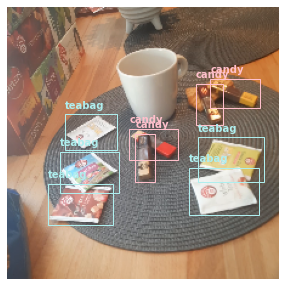

In [6]:
# plotting the image with bboxes. Feel free to change the index
im, target = dataset[0]
plot_im_bbox(torch.reshape(im, (224, 224, 3)), target, plotsize=(5, 5))

## Augmentation

In [ ]:
!pip install albumentations==0.4.6

import albumentations
from albumentations.pytorch.transforms import ToTensorV2

Transformation (random rotation):


In [8]:
def get_transform():
    return albumentations.Compose([albumentations.RandomRotate90(p=1.0)],
                                  bbox_params= {'format': 'pascal_voc', 
                                                'label_fields': ['labels']} )

## Dataloaders

In [ ]:
!git clone https://github.com/pytorch/vision.git
%cd vision
!git checkout v0.3.0
%cd ..

In [10]:
!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

In [11]:
import utils

dataset = ImagesDataset(train_dir, 480, 480, class_names, get_transform())
dataset_val = ImagesDataset(train_dir, 480, 480, class_names)

torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
# train test split
test_split = 0.2
tsize = int(len(dataset) * test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_val = torch.utils.data.Subset(dataset_val, indices[-tsize:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
  dataset,
  batch_size=8,
  shuffle=True,
  num_workers=2,
  collate_fn=utils.collate_fn,
)

data_loader_val = torch.utils.data.DataLoader(
  dataset_val,
  batch_size=8,
  shuffle=False,
  num_workers=2,
  collate_fn=utils.collate_fn,
)

## Pre-trained Model

In [12]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_object_detection_model(num_classes):
    # load a model pre-trained on COCO 
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
    return model

## Training

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 3 # one class (class 0) is dedicated to the "background"

model = get_object_detection_model(num_classes)
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

# a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(
  optimizer,
  step_size=3,
  gamma=0.1
)

In [14]:
def save_checkpoint(epoch, model, optimizer, loss, path):
    torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': loss,
              }, path)

In [ ]:
from engine import train_one_epoch, evaluate

num_epochs = 2
save_regularity = 1
checkpoints_path = f"/content/drive/MyDrive/cv-course-weights/task3/faster-rcnn-v2/round0"

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=1)
    lr_scheduler.step()
    coco_evaluator = evaluate(model, data_loader_val, device=device)
    
    path = checkpoints_path + f"/model-epoch{epoch}.pt"
    if epoch % save_regularity == 0:
        save_checkpoint(epoch, model, optimizer, None, path)
